## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [2]:
df = pd.read_csv('overreg_data.csv', index_col=False)

In [3]:
df.info()
len(df.filename.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14153 entries, 0 to 14152
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         14153 non-null  object 
 1   language         14153 non-null  object 
 2   corpus           14153 non-null  object 
 3   code             14153 non-null  object 
 4   age              4671 non-null   object 
 5   sex              8324 non-null   object 
 6   group            1064 non-null   object 
 7   name             14153 non-null  object 
 8   mlu_words        14153 non-null  float64
 9   correct_count    14153 non-null  int64  
 10  overreg_count    14153 non-null  int64  
 11  correct          9502 non-null   object 
 12  overreg          744 non-null    object 
 13  utterance_count  14153 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 1.5+ MB


4589

In [4]:
df.head()

,filename,language,corpus,code,age,sex,group,name,mlu_words,correct_count,overreg_count,correct,overreg,utterance_count
0,./transcripts\000530.cha,eng,Soderstrom,MOT,NaN,female,NaN,Debby,3.966400,49,0,did did did did did said did got did fell brok...,NaN,625
1,./transcripts\000530.cha,eng,Soderstrom,FAT,NaN,male,NaN,Jim,3.719101,3,0,got did did,NaN,89
2,./transcripts\000530.cha,eng,Soderstrom,CHI,0;05.30,male,NaN,Joseph,1.217391,0,0,NaN,NaN,184
3,./transcripts\000530.cha,eng,Soderstrom,BRO,NaN,NaN,NaN,Thomas,2.351852,1,0,did,NaN,54
4,./transcripts\000530.cha,eng,Soderstrom,SIS,NaN,NaN,NaN,Catherine,2.185185,3,0,did did did,NaN,54


In [5]:
child_df = df[df.code == 'CHI']
child_df = child_df[child_df.age.notna()]
child_df = child_df[child_df.sex.notna()]
child_df = child_df[child_df.overreg_count + child_df.correct_count > 0]
child_df['overreg_rate'] = child_df.overreg_count / (child_df.overreg_count + child_df.correct_count)

# Reformat Age

def age_reformat(age_string):
    years_string = age_string[0: age_string.index(';')]
    months_string = age_string[age_string.index(';') + 1: age_string.index('.')]
    days_string = age_string[age_string.index('.') + 1:]
    years = 0
    months = 0
    days = 0
    if years_string != '':
        years = int(years_string)
    if months_string != '':
        months = int(months_string)
    if days_string != '':
        days = int(days_string)
    return years + (months / 12) + (days / 30.4 / 12)
child_df.age = child_df.age.apply(age_reformat)

In [6]:
child_df.info()
print(child_df.corpus.unique())
child_df.name.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2864 entries, 175 to 14138
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         2864 non-null   object 
 1   language         2864 non-null   object 
 2   corpus           2864 non-null   object 
 3   code             2864 non-null   object 
 4   age              2864 non-null   float64
 5   sex              2864 non-null   object 
 6   group            761 non-null    object 
 7   name             2864 non-null   object 
 8   mlu_words        2864 non-null   float64
 9   correct_count    2864 non-null   int64  
 10  overreg_count    2864 non-null   int64  
 11  correct          2855 non-null   object 
 12  overreg          491 non-null    object 
 13  utterance_count  2864 non-null   int64  
 14  overreg_rate     2864 non-null   float64
dtypes: float64(3), int64(3), object(9)
memory usage: 358.0+ KB
['Brent' 'PetersonMcCabe' 'Braunwald' 'McCun

array(['Henry', 'Dillon', 'Maggie', 'Mary', 'Alexander', 'Laura', 'Alice',
       'Ross', 'Eve', 'Naomi', 'Tow', 'Seth', 'She', 'Emily',
       'Target_Child', 'Nina', 'Lew', 'Trevor', 'Jillian', 'Tim',
       'Steven', 'Jimmy', 'Shem', 'Roman', 'Michael', 'Peter', 'Adam',
       'Matt', 'Sarah', 'Abe', 'Nathaniel', 'Emma', 'Mark', 'Travis',
       'Terran', 'Keisha', 'Rachel', 'Temetrius', 'Tony', 'Jeremiah',
       'Tonisha', 'Jeremy', 'Katherine', 'Tara', 'John', 'Trenice',
       'Andre', 'Trene', 'Justin', 'Tatum', 'Elan', 'Danielle', 'Nicole',
       'Andrew', 'Lorena', 'Veronica', '4697JK24', '5039MB24', '5820CP24',
       '7018NB24', 'Rashawnda', '7120CB24', 'Amanda', 'Rachael', 'Mike',
       'Brian', 'Troy', 'Candice', 'Ryan', 'Desiree', 'Morgan', 'Paul',
       'Anthony', 'Jenny', 'Shell', 'Chrystal', 'Liz', 'Alfred', 'Allen',
       'Anne', 'Amy', 'Andy', 'Anna', 'April', 'Ari', 'Astra', 'Ben',
       'Beth', 'Betty', 'Bev', 'Bill', 'Bobby', 'Bob', 'Brad', 'Brett',
       '

In [7]:
# Merge by person
column_names = ['corpus', 'name', 'appearences', 'sex', 'correct_count', 'overreg_count', 'utterance_count', 'mlu_w', 'min_age', 'max_age']
person_df = pd.DataFrame(columns = column_names)
people = set()
for index, row in child_df.iterrows():
    people.add((row['corpus'], row['name'], row['sex']))
for corpus, name, sex in people:
    base_row = [corpus, name, [], sex, 0, 0, 0, 0, 0, 0]
    for index, row in child_df.iterrows():
        if row['name'] == name and row['corpus'] == corpus and row['sex'] == sex:
            base_row[2].append(row['age'])
            base_row[4] += row['correct_count']
            base_row[5] += row['overreg_count']
            base_row[6] += row['utterance_count']
            base_row[7] = row['mlu_words']
    base_row[8] = min(base_row[2])
    base_row[9] = max(base_row[2])
    base_row[2] = len(base_row[2])
    person_df.loc[len(person_df.index)] = base_row

person_df    
    

,corpus,name,appearences,sex,correct_count,overreg_count,utterance_count,mlu_w,min_age,max_age
0,Garvey,Kim,1,female,3,0,78,3.448718,3.000000,3.000000
1,Bates,Olivia,1,female,2,0,60,2.300000,2.333333,2.333333
2,Hicks,Mirra,3,female,34,0,98,7.000000,6.583333,6.583333
3,Gleason,Helen,1,female,24,5,385,3.581818,4.922149,4.922149
4,Hall,Bobby,2,male,403,7,5762,3.993731,4.750000,4.750000
...,...,...,...,...,...,...,...,...,...,...
367,Gelman,Target_Child,113,male,661,36,16930,5.893333,3.933114,5.079496
368,Gleason,William,1,male,8,0,237,2.890295,2.210526,2.210526
369,Warren,Louise,1,female,15,0,165,3.187879,5.250000,5.250000
370,Garvey,Ben,1,male,2,0,136,2.882353,3.583333,3.583333


In [8]:
pd.set_option('display.max_rows', None)
person_df

,corpus,name,appearences,sex,correct_count,overreg_count,utterance_count,mlu_w,min_age,max_age
0,Garvey,Kim,1,female,3,0,78,3.448718,3.000000,3.000000
1,Bates,Olivia,1,female,2,0,60,2.300000,2.333333,2.333333
2,Hicks,Mirra,3,female,34,0,98,7.000000,6.583333,6.583333
3,Gleason,Helen,1,female,24,5,385,3.581818,4.922149,4.922149
4,Hall,Bobby,2,male,403,7,5762,3.993731,4.750000,4.750000
5,Garvey,Fay,2,female,8,0,188,6.418367,5.250000,5.250000
6,Garvey,Peg,2,female,15,0,340,4.467456,3.083333,3.083333
7,Suppes,Nina,37,female,441,49,23992,4.263318,1.960526,3.271930
8,Hicks,Josh,3,male,51,1,152,7.148649,6.083333,6.083333
9,Gleason,Olivia,1,female,1,0,289,2.370242,3.293860,3.293860


In [9]:
person_df_reduced = person_df[person_df['utterance_count'] > 1000]
len(person_df_reduced)

67

In [10]:
sum(person_df_reduced['sex'] == 'male')

38

In [11]:
person_df_reduced['overreg_rate'] = person_df_reduced['overreg_count'] / (person_df_reduced['correct_count'] + person_df_reduced['overreg_count'])

C:\Users\eliot\AppData\Local\Temp/ipykernel_5960/3891249441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_df_reduced['overreg_rate'] = person_df_reduced['overreg_count'] / (person_df_reduced['correct_count'] + person_df_reduced['overreg_count'])


In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
person_df_reduced

,corpus,name,appearences,sex,correct_count,overreg_count,utterance_count,mlu_w,min_age,max_age,overreg_rate
4,Hall,Bobby,2,male,403,7,5762,3.993731,4.750000,4.750000,0.017073
7,Suppes,Nina,37,female,441,49,23992,4.263318,1.960526,3.271930,0.1
29,Hall,Brett,1,male,188,2,2547,4.372988,4.750000,4.750000,0.010526
32,Post,She,5,female,34,1,1302,2.842466,1.710526,2.336075,0.028571
35,Hall,Patrick,1,male,158,4,1832,3.713428,4.750000,4.750000,0.024691
38,Hall,Remi,1,male,122,0,1418,3.724260,4.750000,4.750000,0.0
52,Hall,Anthony,1,male,219,0,1787,4.419138,4.750000,4.750000,0.0
54,Hall,Gabriel,1,male,173,13,3400,4.078824,4.750000,4.750000,0.069892
65,Kuczaj,Abe,147,male,2317,252,21897,4.850394,2.399123,5.030154,0.098093
67,Weist,Emily,13,female,340,28,4267,5.291139,2.516447,3.358004,0.076087


In [13]:
print(sum(person_df_reduced[person_df_reduced.sex == 'male'].overreg_rate) / len(person_df_reduced[person_df_reduced.sex == 'male']))
print(sum(person_df_reduced[person_df_reduced.sex == 'female'].overreg_rate) / len(person_df_reduced[person_df_reduced.sex == 'female']))
print(sum(person_df_reduced.utterance_count))
female = person_df_reduced[person_df_reduced.sex == 'female']
male = person_df_reduced[person_df_reduced.sex == 'male']
high_fem = female[female.overreg_rate > 0.043]
high_m = male[male.overreg_rate > 0.0301]
print(high_fem.overreg_rate.mean())
print(high_fem.overreg_rate.std())
print(high_m.overreg_rate.mean())
print(high_m.overreg_rate.std())
ttest_ind(high_fem.overreg_rate, high_m.overreg_rate)

0.02220437042014956
0.040905052562839835
458577
0.08859107765943268
0.028847858804745507
0.056932154414119904
0.02182801743668944


Ttest_indResult(statistic=2.767467374414927, pvalue=0.012690105105244511)

In [14]:
print(person_df_reduced[person_df_reduced.sex == 'male'].overreg_rate.std(ddof=0))
print(person_df_reduced[person_df_reduced.sex == 'female'].overreg_rate.std(ddof=0))
ttest_ind(person_df_reduced[person_df_reduced.sex == 'male'].overreg_rate, person_df_reduced[person_df_reduced.sex == 'female'].overreg_rate)

0.025096404702207965
0.04004465247601095


Ttest_indResult(statistic=-2.303915582470175, pvalue=0.024433782144485886)

In [15]:
print(person_df_reduced[person_df_reduced.sex == 'male'].min_age.mean())
print(person_df_reduced[person_df_reduced.sex == 'male'].max_age.mean())
print(person_df_reduced[person_df_reduced.sex == 'female'].min_age.mean())
print(person_df_reduced[person_df_reduced.sex == 'female'].max_age.mean())
print(person_df_reduced[person_df_reduced.sex == 'male'].min_age.std(ddof=0))
print(person_df_reduced[person_df_reduced.sex == 'male'].max_age.std(ddof=0))
print(person_df_reduced[person_df_reduced.sex == 'female'].min_age.std(ddof=0))
print(person_df_reduced[person_df_reduced.sex == 'female'].max_age.std(ddof=0))
print(ttest_ind(person_df_reduced[person_df_reduced.sex == 'male'].min_age, person_df_reduced[person_df_reduced.sex == 'female'].min_age))
print(ttest_ind(person_df_reduced[person_df_reduced.sex == 'male'].max_age, person_df_reduced[person_df_reduced.sex == 'female'].max_age))
print(person_df_reduced[person_df_reduced.sex == 'male'].mlu_w.mean())
print(person_df_reduced[person_df_reduced.sex == 'female'].mlu_w.mean())
print(person_df_reduced[person_df_reduced.sex == 'male'].mlu_w.std(ddof=0))
print(person_df_reduced[person_df_reduced.sex == 'female'].mlu_w.std(ddof=0))
print(ttest_ind(person_df_reduced[person_df_reduced.sex == 'male'].mlu_w, person_df_reduced[person_df_reduced.sex == 'female'].mlu_w))

3.7805719067405357
4.604844759926132
3.171865547489413
4.439371597096189
1.2048858649323382
1.4518812664705412
1.3725544538860608
2.0883031152586313
Ttest_indResult(statistic=1.899403393290061, pvalue=0.06195032165211469)
Ttest_indResult(statistic=0.37644557053654815, pvalue=0.7078117031285953)
3.8751014745481256
4.091161210961215
0.8057973099753428
1.3685381535474206
Ttest_indResult(statistic=-0.7948844933009543, pvalue=0.42957361993960663)


C:\Users\eliot\AppData\Local\Temp/ipykernel_5960/326373962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_df_reduced['overreg_rate'] = pd.to_numeric(person_df_reduced['overreg_rate'])


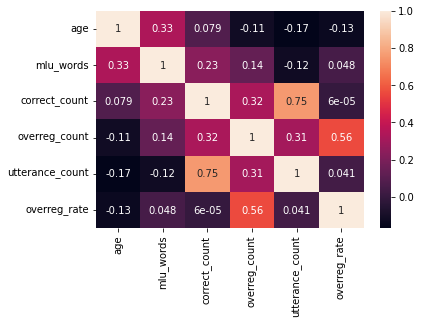

In [16]:
person_df_reduced['overreg_rate'] = pd.to_numeric(person_df_reduced['overreg_rate'])
sns.heatmap(child_df.corr(), annot=True);

[Text(0, 0.5, 'Over-regularization Rate'), Text(0.5, 0, 'MLU-w')]

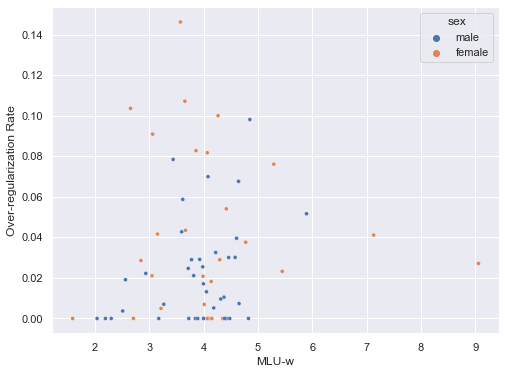

In [17]:
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.scatterplot(data = person_df_reduced, x ='mlu_w', y = 'overreg_rate', hue='sex', s = 16)
ax.set(ylabel='Over-regularization Rate', xlabel='MLU-w')

[Text(0, 0.5, 'Over-regularization Rate'), Text(0.5, 0, 'Minimum Age (Years)')]

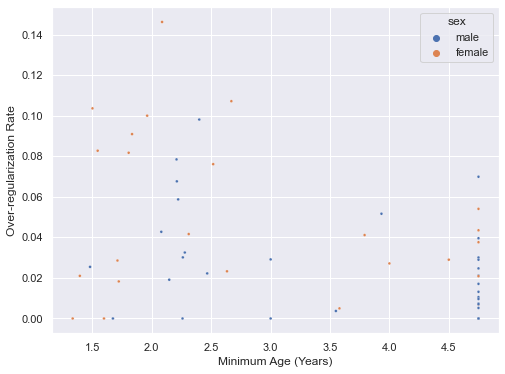

In [18]:
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.scatterplot(data = person_df_reduced, x ='min_age', y = 'overreg_rate', hue='sex', s = 8)
ax.set(ylabel='Over-regularization Rate', xlabel='Minimum Age (Years)')

[Text(0, 0.5, 'Over-regularization Rate'), Text(0.5, 0, 'Maximum Age (Years)')]

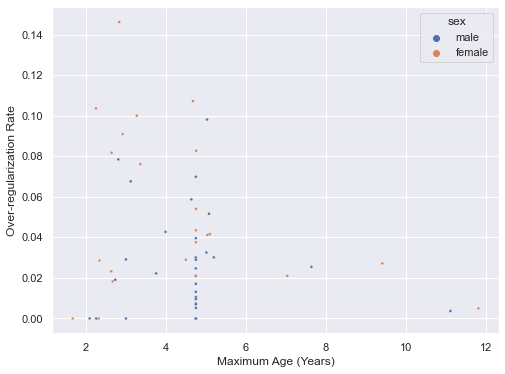

In [19]:
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.scatterplot(data = person_df_reduced, x ='max_age', y = 'overreg_rate', hue='sex', s = 8)
ax.set(ylabel='Over-regularization Rate', xlabel='Maximum Age (Years)')

In [20]:
# Divide into MLU-w Groups
len(person_df_reduced[person_df_reduced.mlu_w < 3.7])
len(person_df_reduced[person_df_reduced.mlu_w > 4.2])
bottom = person_df_reduced[person_df_reduced.mlu_w < 3.7]
middle = person_df_reduced[(person_df_reduced.mlu_w > 3.7) & (person_df_reduced.mlu_w < 4.2)]
top = person_df_reduced[person_df_reduced.mlu_w > 4.2]



In [21]:
# Bottom Group
print(ttest_ind(bottom[bottom.sex == 'male'].overreg_rate, bottom[bottom.sex == 'female'].overreg_rate))
print(bottom[bottom.sex == 'male'].overreg_rate.mean())
print(bottom[bottom.sex == 'male'].overreg_rate.std(ddof=0))
print(bottom[bottom.sex == 'female'].overreg_rate.mean())
print(bottom[bottom.sex == 'female'].overreg_rate.std(ddof=0))

Ttest_indResult(statistic=-1.8710169820704812, pvalue=0.07604674231550293)
0.021086263086507673
0.026035890208213158
0.05341146635089604
0.04803138302876486


In [22]:
# Middle Group
print(ttest_ind(middle[middle.sex == 'male'].overreg_rate, middle[middle.sex == 'female'].overreg_rate))
print(middle[middle.sex == 'male'].overreg_rate.mean())
print(middle[middle.sex == 'male'].overreg_rate.std(ddof=0))
print(middle[middle.sex == 'female'].overreg_rate.mean())
print(middle[middle.sex == 'female'].overreg_rate.std(ddof=0))

Ttest_indResult(statistic=-0.4657301735597665, pvalue=0.6464405202455888)
0.018053868696481797
0.018670478333619473
0.02338663789383179
0.032341477999373355


In [23]:
# Top Group
print(ttest_ind(top[top.sex == 'male'].overreg_rate, top[top.sex == 'female'].overreg_rate))
print(top[top.sex == 'male'].overreg_rate.mean())
print(top[top.sex == 'male'].overreg_rate.std(ddof=0))
print(top[top.sex == 'female'].overreg_rate.mean())
print(top[top.sex == 'female'].overreg_rate.std(ddof=0))

Ttest_indResult(statistic=-1.2748377029727018, pvalue=0.21629202523852442)
0.02693692063998826
0.02852829917273058
0.04313785037977915
0.02825542832656883


In [24]:
len(bottom)

22

In [25]:
len(middle)

22

In [26]:
top

,corpus,name,appearences,sex,correct_count,overreg_count,utterance_count,mlu_w,min_age,max_age,overreg_rate
7,Suppes,Nina,37,female,441,49,23992,4.263318,1.960526,3.271930,0.100000
29,Hall,Brett,1,male,188,2,2547,4.372988,4.750000,4.750000,0.010526
52,Hall,Anthony,1,male,219,0,1787,4.419138,4.750000,4.750000,0.000000
65,Kuczaj,Abe,147,male,2317,252,21897,4.850394,2.399123,5.030154,0.098093
67,Weist,Emily,13,female,340,28,4267,5.291139,2.516447,3.358004,0.076087
82,Weist,Matt,53,male,714,24,10581,4.219409,2.277412,5.013706,0.032520
104,Clark,Shem,26,male,262,19,8987,4.640805,2.210526,3.118969,0.067616
107,Gelman,Target_Child,92,female,443,19,12958,7.130435,3.791118,5.038377,0.041126
108,Brown,Adam,25,male,966,30,20297,4.577858,2.260965,5.199561,0.030120
155,Hall,Samantha,1,female,134,4,2313,4.294423,4.500000,4.500000,0.028986


In [27]:
# Add Average Age

person_df_reduced['av_age'] = (person_df_reduced.min_age + person_df_reduced.max_age) / 2

C:\Users\eliot\AppData\Local\Temp/ipykernel_5960/2042867792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_df_reduced['av_age'] = (person_df_reduced.min_age + person_df_reduced.max_age) / 2


In [28]:
person_df_reduced

,corpus,name,appearences,sex,correct_count,overreg_count,utterance_count,mlu_w,min_age,max_age,overreg_rate,av_age
4,Hall,Bobby,2,male,403,7,5762,3.993731,4.750000,4.750000,0.017073,4.750000
7,Suppes,Nina,37,female,441,49,23992,4.263318,1.960526,3.271930,0.100000,2.616228
29,Hall,Brett,1,male,188,2,2547,4.372988,4.750000,4.750000,0.010526,4.750000
32,Post,She,5,female,34,1,1302,2.842466,1.710526,2.336075,0.028571,2.023300
35,Hall,Patrick,1,male,158,4,1832,3.713428,4.750000,4.750000,0.024691,4.750000
38,Hall,Remi,1,male,122,0,1418,3.724260,4.750000,4.750000,0.000000,4.750000
52,Hall,Anthony,1,male,219,0,1787,4.419138,4.750000,4.750000,0.000000,4.750000
54,Hall,Gabriel,1,male,173,13,3400,4.078824,4.750000,4.750000,0.069892,4.750000
65,Kuczaj,Abe,147,male,2317,252,21897,4.850394,2.399123,5.030154,0.098093,3.714638
67,Weist,Emily,13,female,340,28,4267,5.291139,2.516447,3.358004,0.076087,2.937226


In [29]:
len(person_df_reduced[person_df_reduced.av_age < 4.75])
len(person_df_reduced[person_df_reduced.av_age == 4.75])

32

In [30]:
young = person_df_reduced[person_df_reduced.av_age < 4.75]
old = person_df_reduced[person_df_reduced.av_age >= 4.75]

In [31]:
print(len(young[young.sex == 'male']))
len(young)

15


32

In [32]:
print(ttest_ind(young[young.sex == 'male'].overreg_rate, young[young.sex == 'female'].overreg_rate))
print(young[young.sex == 'male'].overreg_rate.mean())
print(young[young.sex == 'male'].overreg_rate.std(ddof=0))
print(young[young.sex == 'female'].overreg_rate.mean())
print(young[young.sex == 'female'].overreg_rate.std(ddof=0))

Ttest_indResult(statistic=-1.6078722778778016, pvalue=0.11833831112865906)
0.03705265828928196
0.02830013749471262
0.058307469367849724
0.041841542162944154


In [33]:
print(len(old[old.sex == 'male']))
len(old)

23


35

In [34]:
print(ttest_ind(old[old.sex == 'male'].overreg_rate, old[old.sex == 'female'].overreg_rate))
print(old[old.sex == 'male'].overreg_rate.mean())
print(old[old.sex == 'male'].overreg_rate.std(ddof=0))
print(old[old.sex == 'female'].overreg_rate.mean())
print(old[old.sex == 'female'].overreg_rate.std(ddof=0))

Ttest_indResult(statistic=-0.5803253866444251, pvalue=0.5656371942583671)
0.012520704418541475
0.01675422421991354
0.016251628755742476
0.018928939396185708
